In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string

In [3]:
df = pd.read_csv('./data.csv', index_col='Unnamed: 0')

- Dữ liệu thô chưa được làm sạch

In [4]:
df.head(5)

,Bai bao,Chu de
0,Đại học Cần Thơ đã hoàn tất việc xét miễn giảm...,chinh tri xa hoi
1,TP.HCM: sẽ lập trung tâm kiểm định đồng hồ nướ...,chinh tri xa hoi
2,Cung đường nhập lậu gia cầm vào TP HCM\n5h30 s...,chinh tri xa hoi
3,Không thể nghiên cứu khoa học nếu học để đối p...,chinh tri xa hoi
4,Microsoft và Linux sẽ thống trị thị trường ĐTD...,vi tinh


- Tạo hàm clean dữ liệu
    + chuyển về kí tự in thường
    + loại bỏ các dấu câu
    + loại bỏ các chữ có chứa số

In [5]:
def cleaner(text):
    text = text.lower()
    text = ' '.join(word.strip(string.punctuation) for word in text.split())
    text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [6]:
df['Bai bao'] = df['Bai bao'].apply(lambda x: cleaner(x))

- Dữ liệu sau khi đã làm sạch

In [7]:
df.head(5)

,Bai bao,Chu de
0,đại học cần thơ đã hoàn tất việc xét miễn giảm...,chinh tri xa hoi
1,tphcm sẽ lập trung tâm kiểm định đồng hồ nước ...,chinh tri xa hoi
2,cung đường nhập lậu gia cầm vào tp hcm sáng đo...,chinh tri xa hoi
3,không thể nghiên cứu khoa học nếu học để đối p...,chinh tri xa hoi
4,microsoft và linux sẽ thống trị thị trường đtd...,vi tinh


### Tokenize dữ liệu

In [8]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [9]:
def tokenizer(text):
    sentence = rdrsegmenter.tokenize(text)
    return ' '.join(sentence[0])

In [10]:
df['Bai bao'] = df['Bai bao'].apply(lambda x: tokenizer(x))

- Dữ liệu sau khi đã làm sạch và tokenize

In [11]:
df.head(5)

,Bai bao,Chu de
0,đại_học cần_thơ đã hoàn_tất việc xét miễn_giảm...,chinh tri xa hoi
1,tphcm sẽ lập trung_tâm kiểm_định đồng_hồ nước_...,chinh tri xa hoi
2,cung đường nhập lậu gia_cầm vào tp hcm sáng đo...,chinh tri xa hoi
3,không_thể nghiên_cứu khoa_học nếu học để đối_p...,chinh tri xa hoi
4,microsoft và linux sẽ thống_trị thị_trường đtd...,vi tinh


- Kiểm tra độ dài của các chuỗi, độ dài tập trung nhiều trong khoảng từ 0 -> 2000

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


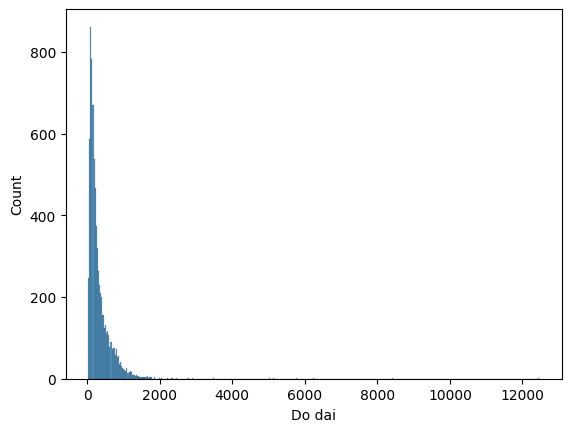

In [4]:
df['Do dai'] = df['Bai bao'].str.count(' ') + 1
sns.histplot(df['Do dai']);

### 1. SVM + TFIDF

In [5]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

- Chia tập dữ liệu train: 80% và test: 20%

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df['Bai bao'], df['Chu de'], test_size=0.2, shuffle=True, random_state=12)

In [7]:
np.array(X_train).shape

(6160,)

- Encode nhãn

In [8]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

- Khởi tạo tfidf với số từ vựng là 1000 và số chiều của 1 văn bản là 1000

In [9]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf.fit(df['Bai bao'])

TfidfVectorizer(max_features=1000)

- Biến đổi dữ liệu thành vector tfidf

In [10]:
X_train_svm = tfidf.transform(X_train)
X_test_svm = tfidf.transform(X_test)

#### SVM

In [11]:
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')
SVM.fit(X_train_svm, y_train)

SVC(gamma='auto', kernel='linear')

In [12]:
preds_svm = SVM.predict(X_test_svm)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1056
           1       0.98      0.96      0.97       484

    accuracy                           0.98      1540
   macro avg       0.98      0.97      0.98      1540
weighted avg       0.98      0.98      0.98      1540



In [14]:
print('Accuracy: ', accuracy_score(y_test, preds_svm)*100)

Accuracy:  98.05194805194806


### 2. LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Embedding
from keras import Model
from keras.preprocessing import sequence

2024-05-08 20:10:16.040890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 20:10:16.041010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 20:10:16.201099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- Sử dụng tokenizer với số từ vựng là 5000 và độ dài vector của mỗi mẫu là 2000

In [16]:
import tensorflow as tf
max_words = 5000
max_len = 2000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

- Định nghĩa model LSTM

In [17]:
def define_model():
    inputs = Input(shape=[max_len])
    layer = Embedding(max_words,50)(inputs)
    layer = LSTM(64)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy', optimizer='Nadam')
    model.summary()
    
    return model

- Khởi tạo model

In [18]:
model = define_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 2000, 50)       │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,505 (1.07 MB)

 Trainable params: 279,505 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(sequences_matrix, y_train, batch_size=64, epochs=10, validation_split=0.2);

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.5224 - val_loss: 0.1165
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.1078 - val_loss: 0.1292
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0701 - val_loss: 0.1211
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0509 - val_loss: 0.1346
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0394 - val_loss: 0.1110
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0180 - val_loss: 0.1214
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0719 - val_loss: 0.1532
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.1068 - val_loss: 0.1686
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0419 - val_loss: 0.1616
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0216 - val_loss: 0.1285


In [20]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [21]:
results = model.evaluate(test_sequences_matrix,y_test)
preds_lstm_embedding = model.predict(test_sequences_matrix)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1649
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [22]:
threshold = 0.5
preds_lstm_embedding = np.where(preds_lstm_embedding > threshold, 1,0)

In [23]:
print(classification_report(y_test, preds_lstm_embedding))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1056
           1       0.98      0.92      0.95       484

    accuracy                           0.97      1540
   macro avg       0.97      0.96      0.96      1540
weighted avg       0.97      0.97      0.97      1540



In [24]:
print('Accuracy: ', accuracy_score(y_test, preds_lstm_embedding)*100)

Accuracy:  96.88311688311688
